### Quality-Diversity (QD) in Webcrawl
Given an `entity` to search, `GPT` first suggests query words for searching Wikipedia. Then, we crawl and summarize (with `GPT`) paragraphs of queried Wikipedia pages. 
We compute the pairwise distances between the summarized sentences using `BERT Score`. 
Finally, we evaluate the distance measures by examining the semantically closest sentences as well as subsampling using `Determinantal Point Processes`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from gpt_helper import set_openai_api_key_from_txt,GPTchatClass,printmd
from wiki_helper import wiki_search
from util import printmd,extract_quoted_words
from bert_score import score
np.set_printoptions(precision=2,suppress=True,linewidth=100)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%matplotlib inline
%config InlineBackend.figure_format='retina'
print ("Ready.")

Ready.


### Set GPT Agent

In [2]:
set_openai_api_key_from_txt(key_path='../key/rilab_key.txt')
GPT = GPTchatClass(
    gpt_model='gpt-3.5-turbo',
    role_msg='Your are a helpful assistant summarizing infromation and answering user queries.')

OpenAI API Key Ready from [../key/rilab_key.txt].
Chat agent using [gpt-3.5-turbo] initialized with the follow role:[Your are a helpful assistant summarizing infromation and answering user queries.]


### Do some wiki crawl

In [3]:
entity = "Isaac Newton"
print ("entity:[%s]"%(entity))

entity:[Isaac Newton]


In [4]:
# Find three query words for the given entity using GPT
user_msg = \
    """
    Suppose you will use Wikipedia for retrieving information. 
    Could you recommend three query words wrapped with quotation marks for getting more information about """ \
    + '"' + entity + '"?' + \
    """ For example, if you are given "stubborn person", you may want to return """ \
    + """ "Characteristic of a stubborn person", "Definition of Stubborn", "Signs of Being Stubborn". """
response_content = GPT.chat(
    user_msg=user_msg,PRINT_USER_MSG=True,PRINT_GPT_OUTPUT=True,
    RESET_CHAT=True,RETURN_RESPONSE=True)
wiki_queries = extract_quoted_words(response_content)
if len(wiki_queries) > 3: wiki_queries = wiki_queries[-3:]
print ("Three query words are\n%s"%(wiki_queries))

[USER_MSG]



    Suppose you will use Wikipedia for retrieving information. 
    Could you recommend three query words wrapped with quotation marks for getting more information about "Isaac Newton"? For example, if you are given "stubborn person", you may want to return  "Characteristic of a stubborn person", "Definition of Stubborn", "Signs of Being Stubborn". 

[GPT_OUTPUT]


Certainly! Here are three query words wrapped with quotation marks for retrieving more information about "Isaac Newton" on Wikipedia:

1. "Early life and education of Isaac Newton"
2. "Scientific achievements of Isaac Newton"
3. "Legacy and impact of Isaac Newton"

These query words will help you find specific sections or articles on Wikipedia that provide detailed information about Isaac Newton's early life, education, scientific contributions, and his overall legacy.

Three query words are
['Early life and education of Isaac Newton', 'Scientific achievements of Isaac Newton', 'Legacy and impact of Isaac Newton']


In [5]:
# Wiki crawl on query words from GPT
paragraphs_return = []
for wiki_query in wiki_queries:
    paragraphs_return += wiki_search(
        entity=wiki_query,min_char_len=100,first_k=3,top_m_excluding_first_k=5,
        VERBOSE=True)
print ("Now we have [%d] paragraphs."%(len(paragraphs_return)))
# Get the unique paragraphs
paragraphs_unique = list(set(paragraphs_return))
print ("Number of paragraphs [%d] => unique ones [%d]"%
       (len(paragraphs_return),len(paragraphs_unique)))

entity:[Early life and education of Isaac Newton] mismatched. use [Early life of Isaac Newton] instead.
 We have total [240] paragraphs.
 After filtering, we have [57] and [8] paragraphs returned (k:[3] and m:[5])
entity:[Scientific achievements of Isaac Newton] mismatched. use [Early life of Isaac Newton] instead.
 We have total [240] paragraphs.
 After filtering, we have [57] and [8] paragraphs returned (k:[3] and m:[5])
entity:[Legacy and impact of Isaac Newton] mismatched. use [Isaac Newton] instead.
 We have total [1413] paragraphs.
 After filtering, we have [142] and [8] paragraphs returned (k:[3] and m:[5])
Now we have [24] paragraphs.
Number of paragraphs [24] => unique ones [16]


In [6]:
# Now summarize each paragraph to a single sentence
summarized_sentences = []
for p_idx,p in enumerate(paragraphs_unique):
    user_msg = "Could you summarize the following paragraph into one setence? \n "+p
    response_content = GPT.chat(
        user_msg=user_msg,PRINT_USER_MSG=False,PRINT_GPT_OUTPUT=False,
        RESET_CHAT=True,RETURN_RESPONSE=True)
    # Append summarized sentences
    summarized_sentences.append(response_content)
    # Print summarized sentence with a markdown format
    print ("[%d/%d]-th Paragraph"%(p_idx,len(paragraphs_unique)))
    printmd(p)
    print ("=>")
    printmd(response_content)

[0/16]-th Paragraph


Isaac Newton1642 births1727 deaths17th-century alchemists17th-century apocalypticists17th-century English astronomers17th-century English mathematicians17th-century English male writers17th-century English writers17th-century Latin-language writers18th-century alchemists18th-century apocalypticists18th-century British astronomers18th-century British scientists18th-century English mathematicians18th-century English male writers18th-century English writers18th-century Latin-language writersAlumni of Trinity College, CambridgeAntitrinitariansBallistics expertsBritish scientific instrument makersBritish writers in LatinBurials at Westminster AbbeyColor scientistsCopernican RevolutionCreators of temperature scalesCritics of atheismEnglish alchemistsEnglish AnglicansEnglish ChristiansEnglish inventorsEnglish justices of the peaceEnglish knightsEnglish mathematiciansEnglish MPs 1689–1690English MPs 1701–1702English physicistsEnlightenment scientistsExperimental physicistsFellows of the Royal SocietyFellows of Trinity College, CambridgeFluid dynamicistsBritish geometersLinear algebraistsHermeticistsHistory of calculusKnights BachelorLucasian Professors of MathematicsMasters of the MintMembers of the pre-1707 Parliament of England for the University of CambridgeNatural philosophersNontrinitarian ChristiansOptical physicistsPeople educated at The King's School, GranthamPeople from South Kesteven DistrictPhilosophers of sciencePost-Reformation Arian ChristiansPresidents of the Royal SocietyReputed virginsTheoretical physicistsWriters about religion and science

=>


Isaac Newton was a 17th and 18th-century English mathematician, physicist, alchemist, and astronomer who made significant contributions to various fields such as optics, mechanics, and calculus, and was also involved in politics and religion.

[1/16]-th Paragraph


Sir Isaac Newton is known for many scientific findings. Some of these discoveries include the laws of motion, the theory of gravity, and basic calculus. Although Newton was predominantly known for his discoveries in mathematics and physics, he also put much effort and study into chemistry, biblical history, and optics. One of Newton's most famous writings was the Principia where he described some of his major findings of time, physics, mathematics, and calculus. Although his theories soon became universal, he faced much opposition to some of his early theories. Specifically, his theory of gravity faced criticism from leading scientists such as Christiaan Huygens and Leibniz. After a few years of debate, Newton's concept of gravity became universally accepted as he became the dominant figure in the European continent. [1]

=>


Sir Isaac Newton is known for his scientific discoveries, including the laws of motion, theory of gravity, calculus, and his famous writing, the Principia, despite facing initial opposition and criticism.

[2/16]-th Paragraph


Sir Isaac Newton FRS (25 December 1642 – 20 March 1726/27)[a] was an English mathematician, physicist, astronomer, alchemist, theologian, and author who was described in his time as a natural philosopher. He was a key figure in the Scientific Revolution and the Enlightenment that followed. His pioneering book Philosophiæ Naturalis Principia Mathematica (Mathematical Principles of Natural Philosophy), first published in 1687, consolidated many previous results and established classical mechanics.[17][18] Newton also made seminal contributions to optics, and shares credit with German mathematician Gottfried Wilhelm Leibniz for developing infinitesimal calculus.

=>


Sir Isaac Newton was a English mathematician, physicist, astronomer, alchemist, theologian, and author, known for his significant contributions to science, particularly in the fields of mechanics and optics, as well as his development of infinitesimal calculus.

[3/16]-th Paragraph


The following article is part of a biography of Sir Isaac Newton, the English mathematician and scientist, author of the Principia. It portrays the years after Newton's birth in 1642, his education, as well as his early scientific contributions, before the writing of his main work, the Principia Mathematica, in 1685.

=>


This article provides an overview of Sir Isaac Newton's early life, education, and scientific contributions before he wrote his main work, the Principia Mathematica.

[4/16]-th Paragraph


In the same work, Newton presented a calculus-like method of geometrical analysis using 'first and last ratios', gave the first analytical determination (based on Boyle's law) of the speed of sound in air, inferred the oblateness of Earth's spheroidal figure, accounted for the precession of the equinoxes as a result of the Moon's gravitational attraction on the Earth's oblateness, initiated the gravitational study of the irregularities in the motion of the Moon, provided a theory for the determination of the orbits of comets, and much more.[73] Newton's biographer David Brewster reported that the complexity of applying his theory of gravity to the motion of the moon was so great it affected Newton's health: "[H]e was deprived of his appetite and sleep" during his work on the problem in 1692–93, and told the astronomer John Machin that "his head never ached but when he was studying the subject". According to Brewster Edmund Halley also told John Conduitt that when pressed to complete his analysis Newton "always replied that it made his head ache, and kept him awake so often, that he would think of it no more". [Emphasis in original][74]

=>


In his work, Newton made significant contributions to calculus, determined the speed of sound in air, explained Earth's oblateness and the precession of the equinoxes, studied the irregularities in the motion of the Moon, developed a theory for the orbits of comets, and more, leading to physical and mental strain on Newton.

[5/16]-th Paragraph


In March 1673 Newton took a prominent part in a dispute in the university. The public oratorship fell vacant, and a contest arose between the heads of the colleges and the members of the Senate as to the mode of electing to the office. The heads claimed the right of nominating two persons, one of whom was to be elected by the senate. The senate insisted that the proper mode was by an open election. George Villiers, 2nd Duke of Buckingham, who was the chancellor of the university, endeavoured to effect a compromise which, he says, "I hope may for the present satisfy both sides. I propose that the heads may for this time nominate and the body comply, yet interposing (if they think fit) a protestation concerning their plea that this election may not hereafter pass for a decisive precedent in prejudice of their claim",[citation needed] and, "whereas I understand that the whole university has chiefly consideration for Dr Henry Paman of St John's College and Mr. Craven of Trinity College, I do recommend them both to be nominated."[citation needed] The heads, however, nominated Drs Paman and Ralph Sanderson (of St John's); the next day 121 members of the senate recorded their votes for Craven and ninety-eight for Paman. On the morning of the election, a protest in which Newton's name appeared was read and entered in the Regent House. But the vice-chancellor admitted Paman the same morning, and so ended the first contest of a non-scientific character in which Newton took part.[citation needed]

=>


In March 1673, Newton participated in a dispute over the election process for the public oratorship at the university, with the heads of the colleges claiming the right to nominate candidates while the senate insisted on an open election; ultimately, Newton's preferred candidate was not elected.

[6/16]-th Paragraph


Isaac Newton was born on Christmas Day, 25 December 1642 Old Style (4 January 1643 on the Gregorian calendar, which is now used)[2] at Woolsthorpe Manor in Woolsthorpe-by-Colsterworth, a hamlet in the county of Lincolnshire. (At the time of Newton's birth, England had not adopted the Gregorian calendar and therefore his date of birth was recorded as 25 December, according to the Julian calendar.)

=>


Isaac Newton was born on December 25, 1642 (according to the Julian calendar) in Woolsthorpe-by-Colsterworth, Lincolnshire.

[7/16]-th Paragraph


Next November, Newton redeemed his promise to Halley by sending him, by the hand of Mr. Paget, a fellow of Trinity College and mathematical master of Christ's Hospital, a copy of his demonstration; and very soon afterward Halley again visited Cambridge to confer with Newton about the problem. On his return to London on 10 December 1684, he informed the Royal Society "that he had lately seen Mr. Newton at Cambridge, who had shown him a curious treatise De Motu",[citation needed] which at Halley's desire he promised to send to the Society to be entered upon their register. "Mr. Halley was desired to put Mr. Newton in mind of his promise for the securing this invention to himself, till he could be at leisure to publish it",[citation needed] and Paget was desired to join with Halley in urging Newton to do so. By the middle of February Newton had sent his paper to Aston, one of the secretaries of the Society, and in a letter to Aston dated 23 February 1685, Newton thanked him for "having entered on the register his notions about motion". This treatise De Motu was the starting point of the Principia,[according to whom?] and was meant[according to whom?] to be a short account of what that work was intended to embrace. It occupies twenty-four octavo pages, and consists of four theorems and seven problems, some of which are identical with some of the most important propositions of the second and third sections of the first book of the  Principia.

=>


In November, Newton fulfilled his promise to Halley by sending him a copy of his demonstration through Mr. Paget; Halley then visited Newton in Cambridge and informed the Royal Society about Newton's treatise De Motu, which he promised to send to the Society for registration, leading to the development of the Principia.

[8/16]-th Paragraph


From this work, he concluded that the lens of any refracting telescope would suffer from the dispersion of light into colours (chromatic aberration). As a proof of the concept, he constructed a telescope using reflective mirrors instead of lenses as the objective to bypass that problem.[58][59] Building the design, the first known functional reflecting telescope, today known as a Newtonian telescope,[59] involved solving the problem of a suitable mirror material and shaping technique. Newton ground his own mirrors out of a custom composition of highly reflective speculum metal, using Newton's rings to judge the quality of the optics for his telescopes. In late 1668,[60] he was able to produce this first reflecting telescope. It was about eight inches long and it gave a clearer and larger image. In 1671, the Royal Society asked for a demonstration of his reflecting telescope.[61] Their interest encouraged him to publish his notes, Of Colours,[62] which he later expanded into the work Opticks. When Robert Hooke criticised some of Newton's ideas, Newton was so offended that he withdrew from public debate. Newton and Hooke had brief exchanges in 1679–80, when Hooke, appointed to manage the Royal Society's correspondence, opened up a correspondence intended to elicit contributions from Newton to Royal Society transactions,[63] which had the effect of stimulating Newton to work out a proof that the elliptical form of planetary orbits would result from a centripetal force inversely proportional to the square of the radius vector. But the two men remained generally on poor terms until Hooke's death.[64]

=>


Sir Isaac Newton concluded that refracting telescopes suffer from chromatic aberration, and to overcome this problem, he constructed the first functional reflecting telescope using mirrors instead of lenses, which he ground himself using a custom composition of highly reflective speculum metal.

[9/16]-th Paragraph


He then points out why "the object-glass of any telescope cannot collect all the rays which come from one point of an object, to make them convene at its focus in less room than in a circular space, whose diameter is the 50th part of the diameter of its aperture: which is an irregularity some hundreds of times greater, than a circularly figured lens, of so small a section as the object-glasses of long telescopes are, would cause by the unfitness of its figure, were light uniform."[citation needed] He adds: "This made me take reflections into consideration, and finding them regular so that the Angle of Reflection of all sorts of Rays was equal to their Angle of Incidence; I understood, that by their mediation optic instruments might be brought to any degree of perfection imaginable, provided a reflecting substance could be found, which would polish as finely as glass, and reflect as much light, as glass transmits, and the art of communicating to it a parabolic figure be also attained. But these seemed very great difficulties, and I have almost thought them insuperable, when I further considered, that every irregularity in a reflecting superficies makes the rays stray 5 or 6 times more out of their due course, than the like irregularities in a refracting one; so that a much greater curiosity would be here requisite, than in figuring glasses for refraction.[citation needed]

=>


In this paragraph, the author discusses the limitations of telescopes in collecting all the rays from an object and suggests that reflections could be a solution to improve the performance of optical instruments, but acknowledges the difficulties in finding a suitable reflecting material and achieving a parabolic figure on its surface.

[10/16]-th Paragraph


During the years 1666 to 1669 Newton's studies were very diverse. He bought prisms and lenses on two or three occasions, and also chemicals and a furnace, apparently for chemical experiments[citation needed]; but he also employed part of his time on the theory of fluxions and other branches of pure mathematics. He wrote a paper, De Analysi per Aequationes Numero Terminorum Infinitas, which he put, probably in June 1669, into the hands of Isaac Barrow (then Lucasian Professor of Mathematics), at the same time permitting him to communicate its contents to their common friend John Collins (1624–1683), a mathematician of no mean order. Barrow did so on 31 July 1669, but kept the name of the author a secret, and merely told Collins that he was a friend staying at Cambridge, who had a powerful genius for such matters.[according to whom?] In a subsequent letter on 20 August Barrow expressed his pleasure at hearing the favourable opinion which Collins had formed of the paper, and added, "the name of the author is Newton, a fellow of our college, and a young man, who is only in his second year since he took the degree of Master of Arts, and who, with an unparalleled genius (examine quo est acumen), has made very great progress in this branch of mathematics".[citation needed] Shortly afterward Barrow resigned his chair and was instrumental in securing Newton's election as his successor.

=>


During the years 1666 to 1669, Newton engaged in diverse studies including purchasing prisms, lenses, chemicals, and a furnace for experimentation, while also dedicating time to the theory of fluxions and other areas of pure mathematics. He wrote a paper called De Analysi per Aequationes Numero Terminorum Infinitas, which he entrusted to Isaac Barrow, who later revealed the author's name as Newton and praised his exceptional mathematical abilities. Eventually, Barrow resigned and played a crucial role in Newton's election as his successor.

[11/16]-th Paragraph


Newton built the first practical reflecting telescope and developed a sophisticated theory of colour based on the observation that a prism separates white light into the colours of the visible spectrum. His work on light was collected in his highly influential book Opticks, published in 1704. He also formulated an empirical law of cooling, made the first theoretical calculation of the speed of sound, and introduced the notion of a Newtonian fluid. In addition to his work on calculus, as a mathematician Newton contributed to the study of power series, generalised the binomial theorem to non-integer exponents, developed a method for approximating the roots of a function, and classified most of the cubic plane curves.

=>


Newton made significant contributions to various scientific fields, including developing a reflecting telescope and a theory of color, formulating laws of cooling and the speed of sound, introducing the concept of Newtonian fluid, and making contributions to calculus and mathematics.

[12/16]-th Paragraph


In the Principia, Newton formulated the laws of motion and universal gravitation that formed the dominant scientific viewpoint for centuries until it was superseded by the theory of relativity. Newton used his mathematical description of gravity to derive Kepler's laws of planetary motion, account for tides, the trajectories of comets, the precession of the equinoxes and other phenomena, eradicating doubt about the Solar System's heliocentricity. He demonstrated that the motion of objects on Earth and celestial bodies could be accounted for by the same principles. Newton's inference that the Earth is an oblate spheroid was later confirmed by the geodetic measurements of Maupertuis, La Condamine, and others, convincing most European scientists of the superiority of Newtonian mechanics over earlier systems.

=>


The paragraph summarizes Newton's accomplishments in the Principia, including his formulation of the laws of motion and universal gravitation, his derivation of Kepler's laws, his explanation of various phenomena, and his confirmation of the Earth's shape.

[13/16]-th Paragraph


All articles with self-published sourcesArticles with self-published sources from January 2023Webarchive template wayback linksWikipedia articles needing page number citations from August 2014All articles with dead external linksArticles with dead external links from June 2017Articles with permanently dead external linksCS1: Julian–Gregorian uncertaintyCS1 French-language sources (fr)Articles with short descriptionShort description matches WikidataWikipedia indefinitely move-protected pagesWikipedia indefinitely semi-protected pagesGood articlesUse British English from March 2020Use dmy dates from December 2022Biography with signatureArticles with hCardsArticles containing Latin-language textPages using sidebar with the child parameterAll articles with specifically marked weasel-worded phrasesArticles with specifically marked weasel-worded phrases from December 2018All articles with unsourced statementsArticles with unsourced statements from December 2018All articles with vague or ambiguous timeVague or ambiguous time from March 2020CS1 maint: bot: original URL status unknownArticles prone to spam from December 2018Articles with hAudio microformatsSpoken articlesArticles with Project Gutenberg linksArticles with Internet Archive linksArticles with LibriVox linksArticles containing French-language textArticles containing Hebrew-language textPages using Sister project links with hidden wikidataArticles with FAST identifiersArticles with ISNI identifiersArticles with VIAF identifiersArticles with WorldCat Entities identifiersArticles with BIBSYS identifiersArticles with BNC identifiersArticles with BNE identifiersArticles with BNF identifiersArticles with BNFdata identifiersArticles with BNMM identifiersArticles with CANTICN identifiersArticles with GND identifiersArticles with ICCU identifiersArticles with J9U identifiersArticles with KBR identifiersArticles with LCCN identifiersArticles with Libris identifiersArticles with LNB identifiersArticles with NCL identifiersArticles with NDL identifiersArticles with NKC identifiersArticles with NLA identifiersArticles with NLG identifiersArticles with NLK identifiersArticles with NSK identifiersArticles with NTA identifiersArticles with PLWABN identifiersArticles with PortugalA identifiersArticles with VcBA identifiersArticles with CINII identifiersArticles with Google Scholar identifiersArticles with MATHSN identifiersArticles with MGP identifiersArticles with ZBMATH identifiersArticles with ULAN identifiersArticles with DTBIO identifiersArticles with Trove identifiersArticles with SNAC-ID identifiersArticles with SUDOC identifiers

=>


The paragraph lists various categories and identifiers associated with articles on Wikipedia, including sources, language, dates, and identifiers.

[14/16]-th Paragraph


АдыгабзэAfrikaansAlemannischአማርኛअंगिकाÆngliscالعربيةAragonésܐܪܡܝܐArmãneashtiArpetanঅসমীয়াAsturianuअवधीAvañe'ẽAymar aruAzərbaycancaتۆرکجهBasa BaliবাংলাBân-lâm-gúBasa BanyumasanБашҡортсаБеларускаяБеларуская (тарашкевіца)भोजपुरीBikol CentralБългарскиBoarischBosanskiBrezhonegБуряадCatalàЧӑвашлаCebuanoČeštinaChavacano de ZamboangaChi-ChewaChiShonaCorsuCymraegDanskالدارجةDeutschދިވެހިބަސްDolnoserbskiडोटेलीEestiΕλληνικάEspañolEsperantoEstremeñuEuskaraفارسیFiji HindiFøroysktFrançaisFryskFurlanGaeilgeGaelgGàidhligGalego贛語Gĩkũyũગુજરાતીगोंयची कोंकणी / Gõychi Konknni客家語/Hak-kâ-ngî한국어HausaHawaiʻiՀայերենहिन्दीHornjoserbsceHrvatskiIdoIlokanoবিষ্ণুপ্রিয়া মণিপুরীBahasa IndonesiaInterlinguaInterlingueИронÍslenskaItalianoעבריתJawaKabɩyɛKalaallisutಕನ್ನಡKapampanganქართულიҚазақшаKernowekKiswahiliKreyòl ayisyenKriyòl gwiyannenKurdîКыргызчаLadinoLatinaLatviešuLëtzebuergeschЛезгиLietuviųLigureLimburgsLingua Franca NovaLivvinkarjalaLa .lojban.LugandaLombardMagyarमैथिलीМакедонскиMalagasyമലയാളംMaltiमराठीმარგალურიمصرىمازِرونیBahasa MelayuMinangkabau閩東語 / Mìng-dĕ̤ng-ngṳ̄MirandésМокшеньМонголမြန်မာဘာသာNāhuatlNederlandsNedersaksiesनेपालीनेपाल भाषा日本語НохчийнNordfriiskNorfuk / PitkernNorsk bokmålNorsk nynorskNovialOccitanОлык марийଓଡ଼ିଆOromooOʻzbekcha / ўзбекчаਪੰਜਾਬੀPangasinanپنجابیပအိုဝ်ႏဘာႏသာႏPapiamentuپښتوPatoisភាសាខ្មែរPicardPiemontèisPlattdüütschPolskiΠοντιακάPortuguêsQaraqalpaqshaRipoarischRomânăRumantschRuna SimiРусиньскыйРусскийСаха тылаसंस्कृतम्ᱥᱟᱱᱛᱟᱲᱤسرائیکیSarduScotsSeelterskShqipSicilianuසිංහලSimple EnglishسنڌيSlovenčinaSlovenščinaСловѣньскъ / ⰔⰎⰑⰂⰡⰐⰠⰔⰍⰟŚlůnskiSoomaaligaکوردیСрпски / srpskiSrpskohrvatski / српскохрватскиSundaSuomiSvenskaTagalogதமிழ்TaclḥitTaqbaylitTarandíneТатарча / tatarçaతెలుగుไทยТоҷикӣTürkçeTürkmençeТыва дылУкраїнськаاردوئۇيغۇرچە / UyghurcheVahcuenghVènetoVepsän kel’Tiếng ViệtVolapükVõroWalon文言West-VlamsWinaray吴语ייִדישYorùbá粵語ZazakiZeêuwsŽemaitėška中文

=>


The paragraph discusses the availability of translation for multiple languages on a website.

[15/16]-th Paragraph


In November 1679, Robert Hooke (after his appointment to manage the Royal Society's correspondence) began an exchange of letters with Newton[citation needed]: he wished to hear from members about their researches, or their views about the researches of others.[20] The correspondence later led to controversy. Hooke and Newton disagreed about the form of the path of a body falling from a height, taking the motion of the Earth around its axis into consideration. Newton later acknowledged that the exchanges of 1679–80 had reawakened his dormant interest in astronomy.[21] This led Newton to revert[according to whom?] to his former conjectures on the Moon. The estimate Newton had used for the radius of the Earth, which had been accepted by geographers and navigators, was based on the very rough estimate that the length of a degree of latitude of the Earth's surface measured along a meridian was 60 nautical miles.[according to whom?] At a meeting of the Royal Society on 11 January 1672, Oldenburg, the secretary, read a letter from Paris describing the procedure followed by Jean Picard in measuring a degree, and specifically stating the precise length that he calculated it to be. It is probable that Newton had become acquainted with this measurement of Picard's, and that he was therefore led to make use of it when his thoughts were redirected to the subject. This estimate of the Earth's magnitude, giving 691 miles (1112  km) to 10°, made the two results, the discrepancy between which Newton had regarded as a disproof of his conjecture, to agree so exactly that he now regarded his conjecture as fully established.

=>


In November 1679, Robert Hooke and Isaac Newton began exchanging letters about their research, specifically regarding the path of a falling body and the Earth's motion, which reignited Newton's interest in astronomy and led him to revise his estimates for the radius of the Earth.

In [7]:
# Compute the pairwise distance between summarized sentences using BERT Score
n_sentence = len(summarized_sentences)
D = np.zeros((n_sentence,n_sentence))
for j_idx in range(n_sentence):
    sentence_i = summarized_sentences
    sentence_j = [summarized_sentences[j_idx]]*n_sentence
    P,R,F1 = score(cands=sentence_i,
                   refs=sentence_j,
                   lang='en',
                   model_type='bert-base-uncased',
                   verbose=False)
    D[j_idx,] = 1.0-F1.numpy()
print ("Done.")

Done.


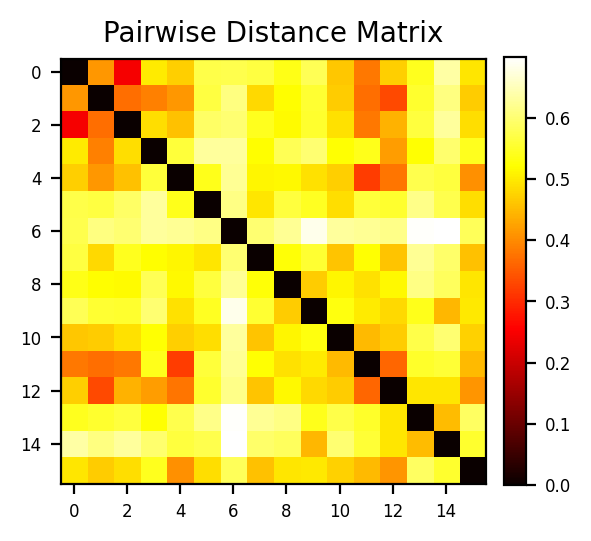

In [8]:
# Plot pairwise distance between sentences
plt.figure(figsize=(3,3))
im = plt.imshow(D,cmap='hot',interpolation='nearest')
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.title('Pairwise Distance Matrix',fontsize=10)
plt.show()

### Check the closest sentence pairs

In [9]:
k_closest_pairs = 3
D_UT = np.triu(m=D,k=1) # get upper-triangular part (+excluding diag)
D_UT[D_UT==0.0] = 100 # exclude zero distances
indices = np.argpartition(a=D_UT,kth=k_closest_pairs,axis=None)[:k_closest_pairs]
distances = D_UT.flat[indices]
sorted_indices = indices[np.argsort(distances)]
i_idxs,j_idxs = np.unravel_index(sorted_indices,D_UT.shape)
for i_idx,j_idx in zip(i_idxs,j_idxs):
    sentence_i = summarized_sentences[i_idx]
    sentence_j = summarized_sentences[j_idx]
    print ("Sentence:[%d] and Sentence:[%d] has dist:[%.4f]"%
           (i_idx,j_idx,D[i_idx,j_idx]))
    printmd (sentence_i)
    printmd (sentence_j)

Sentence:[0] and Sentence:[2] has dist:[0.2476]


Isaac Newton was a 17th and 18th-century English mathematician, physicist, alchemist, and astronomer who made significant contributions to various fields such as optics, mechanics, and calculus, and was also involved in politics and religion.

Sir Isaac Newton was a English mathematician, physicist, astronomer, alchemist, theologian, and author, known for his significant contributions to science, particularly in the fields of mechanics and optics, as well as his development of infinitesimal calculus.

Sentence:[4] and Sentence:[11] has dist:[0.3180]


In his work, Newton made significant contributions to calculus, determined the speed of sound in air, explained Earth's oblateness and the precession of the equinoxes, studied the irregularities in the motion of the Moon, developed a theory for the orbits of comets, and more, leading to physical and mental strain on Newton.

Newton made significant contributions to various scientific fields, including developing a reflecting telescope and a theory of color, formulating laws of cooling and the speed of sound, introducing the concept of Newtonian fluid, and making contributions to calculus and mathematics.

Sentence:[1] and Sentence:[12] has dist:[0.3319]


Sir Isaac Newton is known for his scientific discoveries, including the laws of motion, theory of gravity, calculus, and his famous writing, the Principia, despite facing initial opposition and criticism.

The paragraph summarizes Newton's accomplishments in the Principia, including his formulation of the laws of motion and universal gravitation, his derivation of Kepler's laws, his explanation of various phenomena, and his confirmation of the Earth's shape.

### Subset sampling using `LA-DPP`

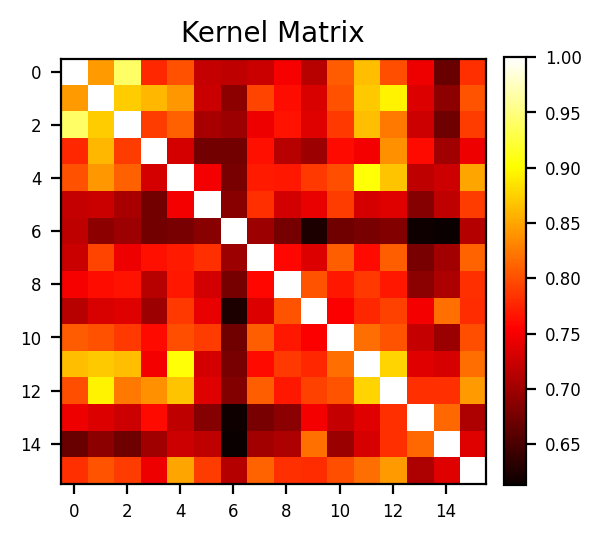

In [10]:
tau = 1.0 # temperature
K = np.exp(-D*D/tau)
# Plot the kernel matrix
plt.figure(figsize=(3,3))
im = plt.imshow(K,cmap='hot',interpolation='nearest')
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.title('Kernel Matrix',fontsize=10)
plt.show()

In [11]:
def get_dpp_subset_from_K(K,n_sel,init_idx=None):
    n_total     = K.shape[0]
    remain_idxs = np.arange(n_total)
    sub_idx     = np.zeros((n_sel))
    sum_K_vec   = np.zeros(n_total)
    for i_idx in range(n_sel):
        if i_idx == 0:
            if init_idx is None:
                sel_idx = np.random.randint(n_total) # random first
            else:
                sel_idx = init_idx
        else:
            curr_K_vec = K[(int)(sub_idx[i_idx-1]),:] 
            sum_K_vec  = sum_K_vec + curr_K_vec
            k_vals     = sum_K_vec[remain_idxs]
            min_idx    = np.argmin(k_vals)
            sel_idx    = remain_idxs[min_idx] 
        sub_idx[i_idx] = (int)(sel_idx)
        remain_idxs = np.delete(remain_idxs,np.argwhere(remain_idxs==sel_idx))
    sub_idx = sub_idx.astype(np.int32) # make it int
    return sub_idx
print ("Ready.")

Ready.


In [12]:
# Among all sentences, find the one that is closest to `entity`
n_sentence = len(summarized_sentences)
refs = ["Information about " + entity]*n_sentence
P,R,F1 = score(cands=summarized_sentences,
               refs=refs,
               lang='en',
               model_type='bert-base-uncased',
               verbose=False)
dists2entity = 1-F1.numpy()
# Print
top_k = 10
k_indices = np.argpartition(dists2entity,top_k)[:top_k]
sorted_k_indices = k_indices[np.argsort(dists2entity[k_indices])]
for i_idx,sentence_idx in enumerate(sorted_k_indices):
    dist = dists2entity[sentence_idx]
    sentence = summarized_sentences[sentence_idx]
    VERBOSE = False
    if VERBOSE:
        print ("[%d/%d] dist:[%.3f]"%(i_idx,top_k,dist))
        printmd(sentence)
print ("Done.")        

Done.


In [13]:
n_sel = 10
idxs_dpp = get_dpp_subset_from_K(K,n_sel=n_sel,init_idx=sorted_k_indices[0])
for i_idx,sentence_idx in enumerate(idxs_dpp):
    sentence = summarized_sentences[sentence_idx]
    printmd(sentence)

Sir Isaac Newton is known for his scientific discoveries, including the laws of motion, theory of gravity, calculus, and his famous writing, the Principia, despite facing initial opposition and criticism.

The paragraph discusses the availability of translation for multiple languages on a website.

Isaac Newton was born on December 25, 1642 (according to the Julian calendar) in Woolsthorpe-by-Colsterworth, Lincolnshire.

In March 1673, Newton participated in a dispute over the election process for the public oratorship at the university, with the heads of the colleges claiming the right to nominate candidates while the senate insisted on an open election; ultimately, Newton's preferred candidate was not elected.

The paragraph lists various categories and identifiers associated with articles on Wikipedia, including sources, language, dates, and identifiers.

Sir Isaac Newton concluded that refracting telescopes suffer from chromatic aberration, and to overcome this problem, he constructed the first functional reflecting telescope using mirrors instead of lenses, which he ground himself using a custom composition of highly reflective speculum metal.

This article provides an overview of Sir Isaac Newton's early life, education, and scientific contributions before he wrote his main work, the Principia Mathematica.

In this paragraph, the author discusses the limitations of telescopes in collecting all the rays from an object and suggests that reflections could be a solution to improve the performance of optical instruments, but acknowledges the difficulties in finding a suitable reflecting material and achieving a parabolic figure on its surface.

In November, Newton fulfilled his promise to Halley by sending him a copy of his demonstration through Mr. Paget; Halley then visited Newton in Cambridge and informed the Royal Society about Newton's treatise De Motu, which he promised to send to the Society for registration, leading to the development of the Principia.

Isaac Newton was a 17th and 18th-century English mathematician, physicist, alchemist, and astronomer who made significant contributions to various fields such as optics, mechanics, and calculus, and was also involved in politics and religion.